# **Varying the number of channels**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**

In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import summary libraries for model information
from torchsummary import summary

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# extra imports
import copy

In [2]:
# Import and inspect the data
# cdata=tv.datasets.EMNIST(root='emnist',split='letters')
cdata=tv.datasets.EMNIST(root='emnist',split='letters',download=True)


In [3]:
#inspect the data

# the categories (but how many letters?)

print(cdata.classes)
print(str(len(cdata.classes))+'classes')

print("\nData Size:")
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images=cdata.data.view([124800,1,28,28]).float()
print('\nTensor Data: ')
print(images.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27classes

Data Size:
torch.Size([124800, 28, 28])

Tensor Data: 
torch.Size([124800, 1, 28, 28])


In [4]:
# brief aside: class 'N/A' doesn't exist in the data
print(tr.sum(cdata.targets==0))

# however, it causes problems in one-hot encoding...
tr.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [5]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [6]:
# so therefore we'll eliminate 'N/A' and subtract 1 from the original labels

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels=copy.deepcopy(cdata.targets)-1
print(labels.shape)

print(tr.sum(labels==0))
print(tr.unique(labels))


torch.Size([124800])
tensor(4800)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


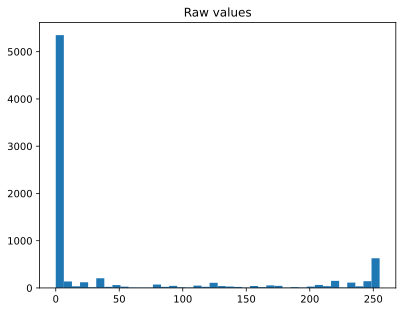

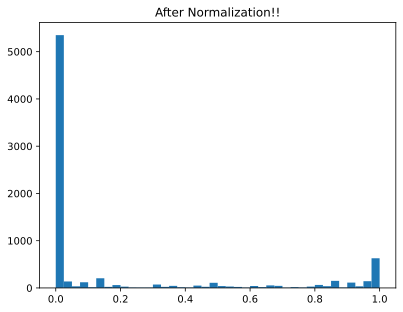

In [7]:
# next issue: do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

# yarp.{Means YES!}
images/=tr.max(images)
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('After Normalization!!')
plt.show()

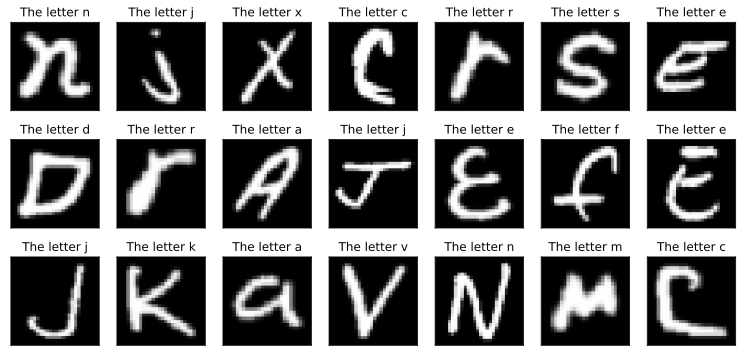

In [8]:
# visualization of some images
fig,axs=plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic=np.random.randint(images.shape[0])

  # extract the image and its target letter
  I=np.squeeze(images[whichpic,:,:])
  letter=letterCategories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title(f'The letter {letter}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()


In [9]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,labels,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [10]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [11]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

In [12]:
# creating a class for the model

convOutChannels=[64,128]
imgSize=(28,28)
kernelSize=(3,3)
strideSize=(1,1)
paddingSize=(1,1)
poolSize=(2,2)
fc_nodes=50
out_nodes=26

def createNet(convOutChannels,printtoggle=False):
    class mnistNet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            ### convolution layers

            # first convolution layer
            # conv 1
            self.conv1=nn.Conv2d(1,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.bnorm1=nn.BatchNorm2d(convOutChannels[0]) # input the number of channels in this layers
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])

            # second convolutional layer
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.bnorm2=nn.BatchNorm2d(convOutChannels[1]) # input the number of channels in this layers
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])

            ### linear decision layer 

            # fully-connected layer
            self.fci=fcInput(self.outcp2[2],self.outcp2[0])
            self.fc1=nn.Linear(self.fci,fc_nodes)


            # output layer
            self.out=nn.Linear(fc_nodes,out_nodes)

            # toggle for printing out tensor sizes during forward prop
            self.print=printtoggle

        # forward propogation
        def forward(self,x):
            print(f'Input: {x.shape}') if self.print else None

            ### convolution -> maxpool -> relu (1)
            x = F.leaky_relu(self.bnorm1(F.max_pool2d(self.conv1(x),2)))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None

            ### convolution -> maxpool -> relu (2)
            x = F.leaky_relu(self.bnorm2(F.max_pool2d(self.conv2(x),2)))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None

            # reshape for linear layer
            ### x.shape.numel() -->  gives total number of elements in the array/tuple
            nUnits=x.shape.numel()/x.shape[0]
            ### vectorizing
            x=x.view(-1,int(nUnits))
            print(f'Vectorize: {x.shape}') if self.print else None
            
            # linear layers
            x=F.leaky_relu(self.fc1(x))
            print(f'Layer fc1: {x.shape}') if self.print else None

            x=self.out(x)
            print(f'Output: {x.shape}') if self.print else None

            return x
    
    # create the model instance
    net=mnistNet(printtoggle)

    # loss function
    lossfun=nn.CrossEntropyLoss()

    # optimizer
    optimizer=tr.optim.Adam(net.parameters(),lr=0.001)
    
    return net,lossfun,optimizer

In [13]:
# test the model with one batch
net,lossfun,optimizer = createNet((2,2),True)

X,y = next(iter(train_loader))
yHat = net(X)

print('\nLabel size:')
print(y.shape)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,tr.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 2, 14, 14])
Layer conv2/pool2: torch.Size([32, 2, 7, 7])
Vectorize: torch.Size([32, 98])
Layer fc1: torch.Size([32, 50])
Output: torch.Size([32, 26])

Label size:
torch.Size([32])

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.3218, grad_fn=<NllLossBackward0>)


In [14]:
# setting up gpu
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
# count the total number of parameters in the model
net.to(device)
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 2, 14, 14])
Layer conv2/pool2: torch.Size([2, 2, 7, 7])
Vectorize: torch.Size([2, 98])
Layer fc1: torch.Size([2, 50])
Output: torch.Size([2, 26])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 28, 28]              20
       BatchNorm2d-2            [-1, 2, 14, 14]               4
            Conv2d-3            [-1, 2, 14, 14]              38
       BatchNorm2d-4              [-1, 2, 7, 7]               4
            Linear-5                   [-1, 50]           4,950
            Linear-6                   [-1, 26]           1,326
Total params: 6,342
Trainable params: 6,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
-------------------------

In [16]:
# Create a function that trains the model

def trainModel(ch,n_epochs=5):
    # create a new model
    net,lossfun,optimizer=createNet(convOutChannels=ch)

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)
    trainErr = tr.zeros(n_epochs)
    testErr = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]
        batchErr=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchErr.append(tr.mean((tr.argmax(yHat,axis=1)!=y).float()).item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)
        trainErr[epochi]=100*np.mean(batchErr)

        # test accuracy
        X,y=next(iter(test_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()
        testErr[epochi]=100*tr.mean((tr.argmax(yHat,axis=1)!=y).float()).item()

        print(f"{epochi+1}/{n_epochs} complete!")
    # end of epochs

    # function output
    return trainLoss,testLoss,trainErr,testErr,net

In [21]:
# Run the Experiment and show the results!
chs = [2, 5, 8]
print()
results=np.zeros((len(chs),len(chs),2))
convParams=np.zeros((len(chs),len(chs)))

for i,nChani in enumerate(chs):
    for j,nChanj in enumerate(chs):
        trainLoss,testLoss,trainErr,testErr,net=trainModel((nChani,nChanj))
        results[i,j,:]=trainErr[-1],testErr[-1]
        convParams[i,j]=nChani+nChanj
        print(i,j)


1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
0 0
1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
0 1
1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
0 2
1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
1 0
1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
1 1
1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
1 2
1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
2 0
1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
2 1
1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!
2 2


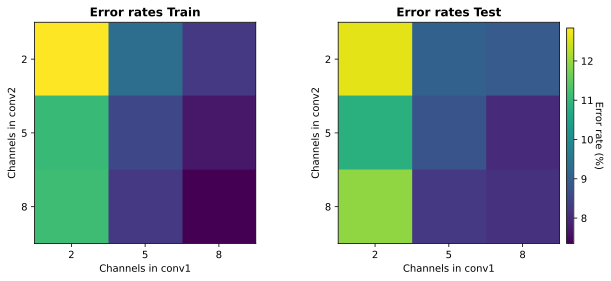

In [22]:
# Show the results matrix

fig,ax = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
  h = ax[i].imshow(results[:,:,i],vmin=np.min(results),vmax=np.max(results))
  ax[i].set_xlabel('Channels in conv1')
  ax[i].set_ylabel('Channels in conv2')
  ax[i].set_xticks(range(j+1)) # j defined in previous cell
  ax[i].set_yticks(range(j+1))
  ax[i].set_xticklabels(chs)
  ax[i].set_yticklabels(chs)
  title = 'Train' if i==0 else 'Test'
  ax[i].set_title('Error rates %s'%title,fontweight='bold')


# add a colorbar right of the plot (use common colorscaling for both plots)
axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1+.01,axpos.y0,.01,.75])
hh = fig.colorbar(h,cax=cax)
hh.set_label('Error rate (%)',rotation=270,labelpad=10)

plt.show()

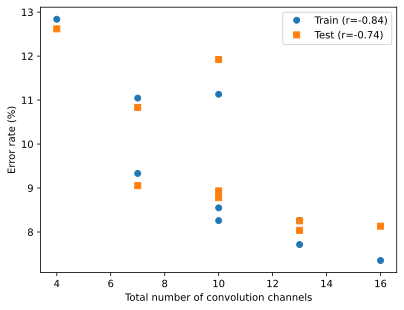

In [23]:
# error rate as a function of the total number of conv channels

corrTrain = np.corrcoef(convParams.flatten(),results[:,:,0].flatten())
corrTest  = np.corrcoef(convParams.flatten(),results[:,:,1].flatten())

# plots
plt.plot(convParams.flatten(),results[:,:,0].flatten(),'o',
         label=f'Train (r={corrTrain[0,1]:.2f})')
plt.plot(convParams.flatten(),results[:,:,1].flatten(),'s',
         label=f'Test (r={corrTest[0,1]:.2f})')

# other stuff etc
plt.legend()
plt.xlabel('Total number of convolution channels')
plt.ylabel('Error rate (%)')
plt.show()

**Additional Explorations**

In [ ]:
# 1) The correlation between error rate and convolution channels looks pretty compelling. How far do you dare go?!?! Try adding more channels. Does the error rate simply keep going down until it reaches zero? Or do you find a point of "diminishing returns", meaning that adding more channels no longer improves performance.

# 2) It seems intuitive that models with more layers take longer to train. But if there's one thing you've learned about deep learning, it's that intuition doesn't always get us very far. Thus: modify the code to track the training time for each model. Store the results in a separate matrix, and make an image of those results. Do they look like what you had expected?

# 3) Are net.train() and net.eval() necessary here? Why or why not?